In [1]:
import napari
import cupy as cp
import numpy as np
import higra as hg
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from cucim.skimage.transform import downscale_local_mean, rescale
from cucim.skimage.filters import gaussian

from skimage.measure import regionprops

import torch as th
import torch.nn.functional as F

from tifffile import imread

from dexp_dl.inference import ModelInference
from dexp_dl.postprocessing import hierarchy
from dexp_dl.models import hrnet, unet
from dexp_dl.transforms import *

In [2]:
### INPUT ###
IM_PATH = '15s 092221 20x without yolk_1_MMStack_Default.ome.tif'
WEIGHTS_PATH = 'logs/hrnet_bn/last.ckpt'
CELL_CHANNEL = 2
Z_SCALE = 2

th.cuda.set_device(0)

### PARAMETERS ###
PRED_THOLD = 0.25
CUT_THOLD = 1
EXP_BLUR = 1

In [3]:
def in_transform(image):
    return th.Tensor(image).unsqueeze_(0).half()


def out_transform(image):
    return th.sigmoid(F.interpolate(image, scale_factor=2, mode='trilinear', align_corners=True))

def normalize(image, upper_limit):
    im_min = image.min()
    image = (image - im_min) / (quantile - im_min)
    return np.clip(image, 0, 1)

net = hrnet.hrnet_w18_small_v2(pretrained=False, in_chans=1, num_classes=3, image_ndim=3)

model = ModelInference(
    net,
    transforms=in_transform,
    after_transforms=out_transform,
    tile=(48, 96, 96), num_outputs=3,
)

model.load_weights(WEIGHTS_PATH)


Missing keys []

Unexpected keys []


In [4]:
image = imread(IM_PATH)
    
# making it anisotropic
image = downscale_local_mean(cp.asarray(image), (1, Z_SCALE, 1, 1)).get()

In [5]:
quantile = np.quantile(image[CELL_CHANNEL], 0.999)
print('Quantile', quantile, 'Maximum', image[CELL_CHANNEL].max())

# normalizing image
norm_image = normalize(image[CELL_CHANNEL], quantile)

Quantile 27757.0 Maximum 59986.0


In [6]:
# deep learning
with th.cuda.amp.autocast():
    pred = model(norm_image)
    
    # displaying
viewer = napari.Viewer()
viewer.add_image(image, channel_axis=0, name='Input image')
viewer.add_image(pred[0], blending='additive', name='Cell prediction')
viewer.add_image(pred[1], blending='additive', name='Distance map')
if len(pred) > 2:
    viewer.add_image(pred[2], blending='additive', name='Denoising')

In [7]:
# computing segmentation
hiers = hierarchy.create_hierarchies(
    pred[0] > PRED_THOLD,
    pred[1],
    hierarchy_fun=hg.watershed_hierarchy_by_area,
    cache=True,
    min_area=10,
    min_frontier=0,
)
    
for h in hiers:
    h.cut_threshold = CUT_THOLD
labels = hierarchy.to_labels(hiers, pred[0].shape)
    
labels_layer = viewer.add_labels(labels)
labels_layer.contour = 1

In [8]:
# blurring expressions
expressions = image[:CELL_CHANNEL].transpose((1, 2, 3, 0))
expressions = gaussian(cp.asarray(expressions, dtype=np.float32), sigma=EXP_BLUR, multichannel=True).get()
viewer.add_image(expressions, name='blurred expressions', channel_axis=3)

[<Image layer 'blurred expressions' at 0x7f0252055c10>,
 <Image layer 'blurred expressions [1]' at 0x7f0252903160>]

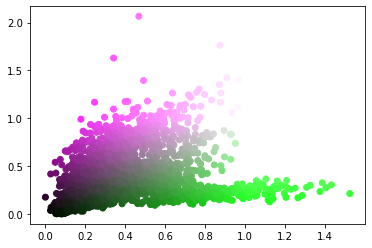

In [9]:
# extracting expressions from segments
props = regionprops(labels, expressions)
    
df = []

for p in props:
    exp1, exp2 = np.median(p.intensity_image[p.image], axis=0)
    df.append([p.label, exp1, exp2, *p.centroid])

df = pd.DataFrame(df, columns=['label', 'tbxt', 'sox2', 'z', 'y', 'x'])

# computing colors
green = np.array([[0, 1, 0, 1]])  # tbxt
magenta = np.array([[1, 0, 1, 1]])  # sox2

def normalize_column(df, column, upper_quantile=0.99):
    col = df[column].values
    col -= col.min()
    col /= np.quantile(col, upper_quantile)
    return np.clip(col, 0, 1)

tbxt = normalize_column(df, 'tbxt')
sox2 = normalize_column(df, 'sox2')

colors = green * tbxt[:, None] + magenta * sox2[:, None]
colors[:,3] = 1 # alpha channel

plt.scatter(x=df['tbxt'], y=df['sox2'], c=colors)

In [10]:
# spreading expression to segments
mask = np.zeros(labels.shape + (2,), dtype=np.uint16)
for p in props:
    exp1, exp2 = np.median(p.intensity_image[p.image], axis=0)
    mask[p.slice + (0,)][p.image] = exp1
    mask[p.slice + (1,)][p.image] = exp2

viewer.add_image(mask, name='painted segments', channel_axis=3)

[<Image layer 'painted segments' at 0x7f024a1e9fa0>,
 <Image layer 'painted segments [1]' at 0x7f0249a0a460>]